![lop](../../images/logo_diive1_128px.png)

<span style='font-size:40px; display:block;'>
<b>
    Random forest gap-filling
</b>
</span>

---
**Notebook version**: `2.1` (11 Jun 2024)  
**Author**: Lukas Hörtnagl (holukas@ethz.ch)  

</br>

# **Background**

- Using random forest to gap-fill time series data

</br>

# **User settings**
`TARGET_COL` ... name of the time series that is gap-filled  
`subsetcols` ... list of columns included in the random forest model, target must also be listed here

All columns that are not the target will be used as features/predictors during model building.

In [1]:
TARGET_COL = 'NEE_CUT_REF_orig'
subsetcols = [TARGET_COL, 'Tair_f', 'VPD_f', 'Rg_f']

</br>

# **Imports**
- This notebook uses `diive` ([source code](https://gitlab.ethz.ch/diive/diive)) to check eddy covariance fluxes for quality

In [2]:
import numpy as np
import importlib.metadata
from datetime import datetime
import matplotlib.pyplot as plt
from diive.configs.exampledata import load_exampledata_parquet
from diive.core.plotting.timeseries import TimeSeries  # For simple (interactive) time series plotting
from diive.core.dfun.stats import sstats  # Time series stats
from diive.core.plotting.heatmap_datetime import HeatmapDateTime
from diive.pkgs.gapfilling.randomforest_ts import RandomForestTS
import warnings
warnings.filterwarnings('ignore')
version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")

diive version: v0.79.0


</br>

# **Docstring** for `RandomForestTS`

In [3]:
# help(RandomForestTS)

</br>

---

# **Load data**

## Load example data from parquet file

In [4]:
source_df = load_exampledata_parquet()

Loaded .parquet file F:\Sync\luhk_work\20 - CODING\21 - DIIVE\diive\diive\configs\exampledata\exampledata_PARQUET_CH-DAV_FP2022.5_2013-2022_ID20230206154316_30MIN.parquet (0.072 seconds). Detected time resolution of <30 * Minutes> / 30min 


## Make subset

In [5]:
df = source_df.copy()
lowquality = df["QCF_NEE"] > 0  # This example uses NEE flux data, only records where the quality flag QCF is 0 (highest quality) are retained
df.loc[lowquality, TARGET_COL] = np.nan  # Set fluxes of lower quality to missing
df = df[subsetcols].copy()  # Keep subset columns only

In [6]:
df.describe()

,NEE_CUT_REF_orig,Tair_f,VPD_f,Rg_f
count,41284.000000,175296.000000,175296.000000,175296.000000
mean,-3.833522,4.712999,3.233176,152.671445
std,6.085449,7.548653,3.710180,247.531312
min,-38.653000,-23.096000,0.000000,0.000000
25%,-7.840000,-0.800000,0.661000,0.000000
50%,-3.827000,4.600000,1.991000,2.596000
75%,0.606250,10.067000,4.375000,225.677750
max,25.290000,28.713000,32.118000,1197.800000


In [7]:
sstats(df[TARGET_COL])

,NEE_CUT_REF_orig
STARTDATE,2013-01-01 00:15
ENDDATE,2022-12-31 23:45
PERIOD,3651 days 23:30:00
NOV,41284
MISSING,134012
MISSING_PERC,76.448978
MEAN,-3.833522
MEDIAN,-3.827
SD,6.085449
VAR,37.032694


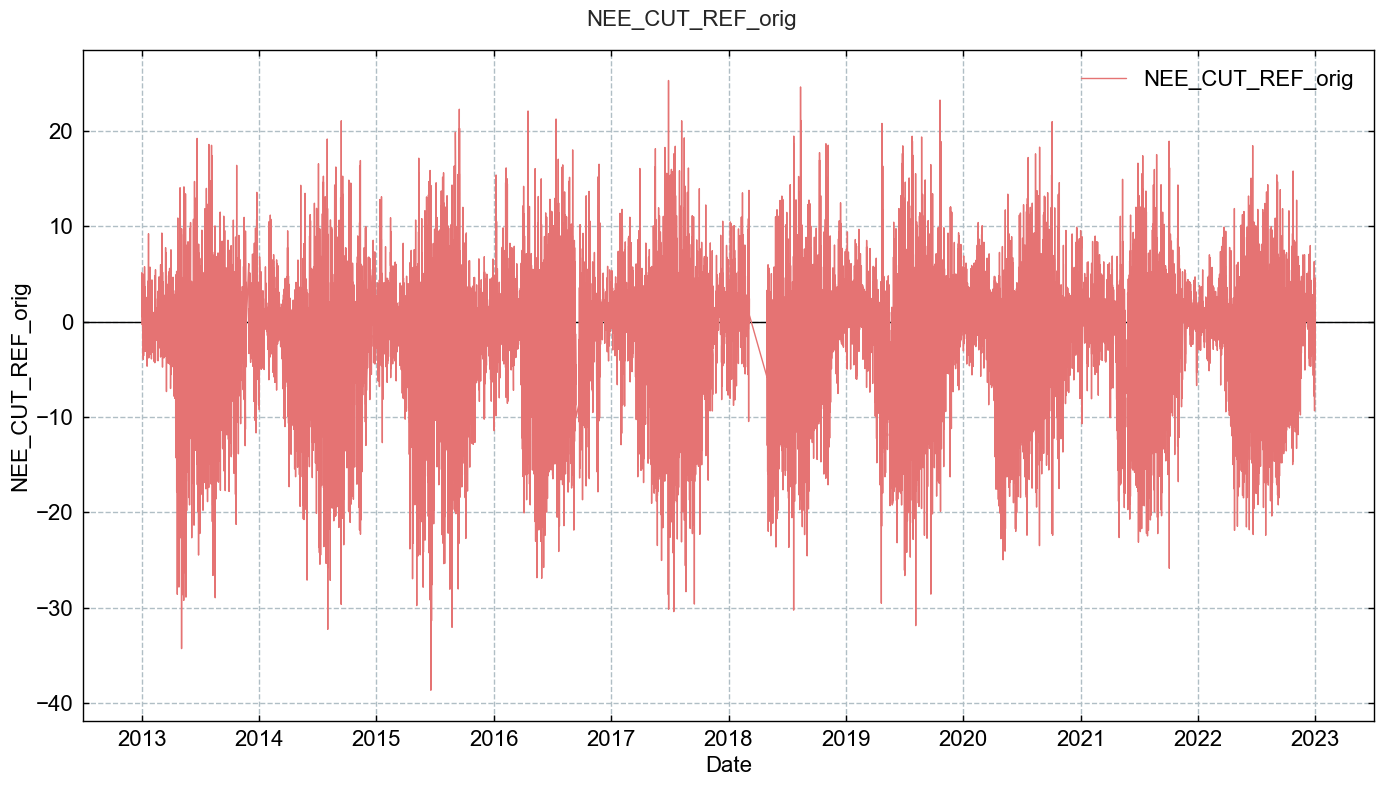

In [8]:
# TimeSeries(series=df[TARGET_COL]).plot_interactive()
TimeSeries(series=df[TARGET_COL]).plot()

</br>

</br>

# **Gap-filling**

## Initialize random forest

In [9]:
# Random forest
rfts = RandomForestTS(
    input_df=df,
    target_col=TARGET_COL,
    verbose=1,    
    features_lag=[-1, -1],    
    include_timestamp_as_features=True,    
    add_continuous_record_number=True,
    sanitize_timestamp=True,
    n_estimators=99,
    random_state=42,
    min_samples_split=2,
    min_samples_leaf=1,
    perm_n_repeats=33,
    n_jobs=-1
)


Adding new data columns ...
++ Added new columns with lagged variants for: ['Tair_f', 'VPD_f', 'Rg_f'] (lags between -1 and -1 with stepsize 1), no lagged variants for: ['NEE_CUT_REF_orig'].
++ Added new columns with timestamp info: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] 
++ Added new column .RECORDNUMBER with record numbers from 1 to 175296.

Sanitizing timestamp ...
>>> Validating timestamp naming of timestamp column TIMESTAMP_MIDDLE ... Timestamp name OK.
>>> Converting timestamp TIMESTAMP_MIDDLE to datetime ... OK
>>> All rows have timestamp TIMESTAMP_MIDDLE, no rows removed.
>>> Sorting timestamp TIMESTAMP_MIDDLE ascending ...
>>> Removing data records with duplicate indexes ... OK (no duplicates found in timestamp index)
>>> Creating continuous <30 * Minutes> timestamp index for timestamp TIMESTAMP_MIDDLE between 2013-01-01 00:15:00 and 2022-12-31 23:45:00 ...


</br>

## Feature reduction

In [10]:
rfts.reduce_features()


Feature reduction based on permutation importance ...
>>> Calculating feature importances (permutation importance, 33 repeats) ...
>>> Setting threshold for feature rejection to 0.03703479849590609.
>>> Removing rejected features from model data ...


In [11]:
rfts.report_feature_reduction()


FEATURE REDUCTION

- Target variable: NEE_CUT_REF_orig

- The random variable .RANDOM was added to the original features, used as benchmark for detecting relevant feature importances.

PERMUTATION IMPORTANCE (mean) across all splits of TimeSeriesSplit:

               PERM_IMPORTANCE   PERM_SD
Rg_f                  1.232897  0.007899
.DOY                  0.241612  0.002963
.Tair_f-1             0.208743  0.002085
.HOUR                 0.155900  0.001548
Tair_f                0.146522  0.001899
.Rg_f-1               0.138716  0.001270
.VPD_f-1              0.130136  0.000960
VPD_f                 0.087728  0.000767
.RECORDNUMBER         0.064164  0.000544
.WEEK                 0.038256  0.000440
.RANDOM               0.037035  0.000294
.YEARMONTH            0.034903  0.000524
.YEARDOY              0.033000  0.000268
.YEARWEEK             0.016380  0.000128
.SEASON               0.006235  0.000420
.MONTH                0.002806  0.000061
.YEAR                 0.002400  0.000031

- Thes

</br>

## Train model


Training final model ...
>>> Training model <class 'sklearn.ensemble._forest.RandomForestRegressor'> based on data between 2013-01-01 01:45:00 and 2022-12-31 22:15:00 ...
>>> Fitting model to training data ...
>>> Using model to predict target NEE_CUT_REF_orig in unseen test data ...
>>> Using model to calculate permutation importance based on unseen test data ...
>>> Plotting feature importances (permutation importance) ...
>>> Calculating prediction scores based on predicting unseen test data of NEE_CUT_REF_orig ...
>>> Plotting observed and predicted values ...


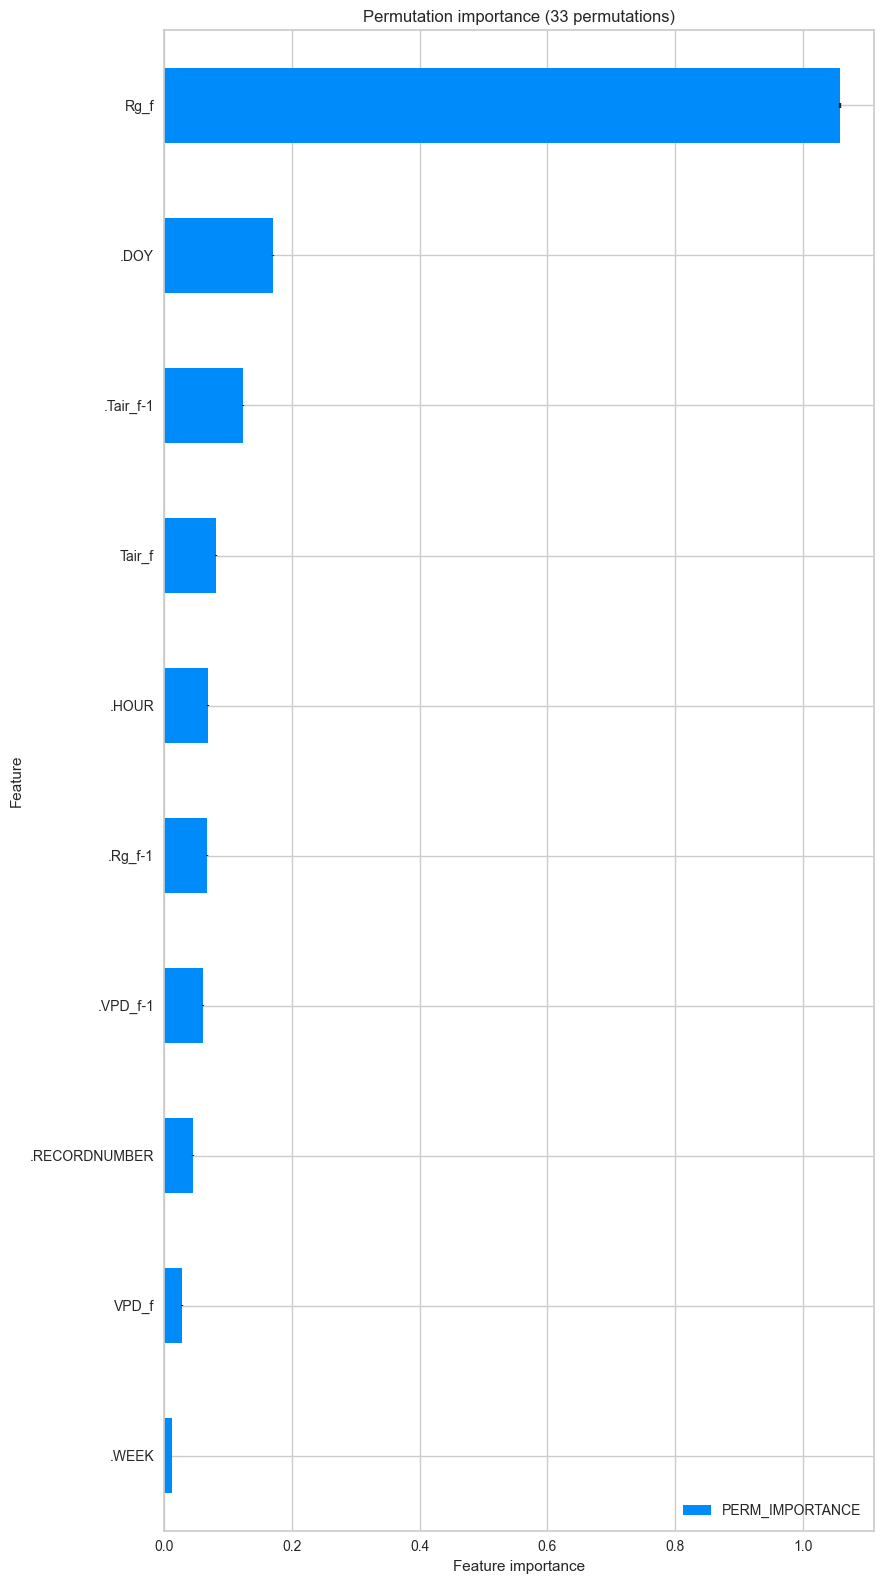

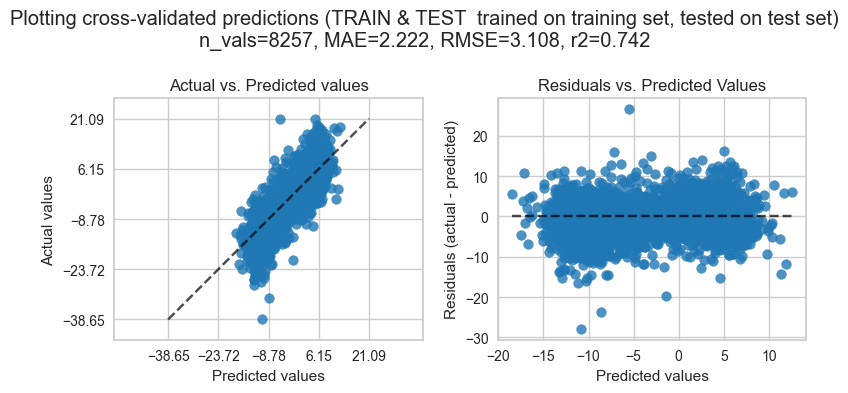

>>> Plotting residuals and prediction error ...


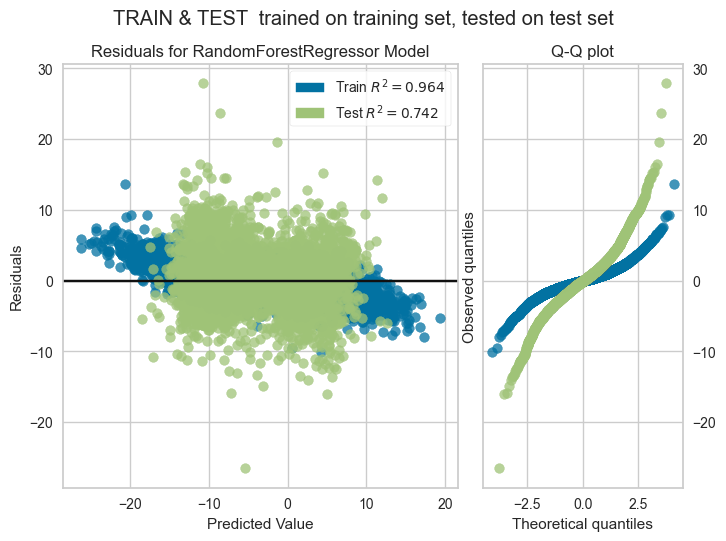

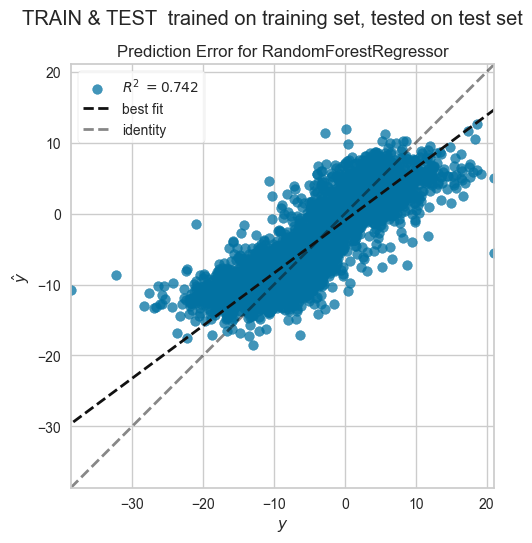

>>> Collecting results, details about training and testing can be accessed by calling .report_traintest().
>>> Done.


In [12]:
rfts.trainmodel(showplot_scores=True, showplot_importance=True)

In [13]:
rfts.report_traintest()


MODEL TRAINING & TESTING RESULTS

## DATA
  > target: NEE_CUT_REF_orig
  > features: 10 ['Rg_f', '.DOY', '.Tair_f-1', '.HOUR', 'Tair_f', '.Rg_f-1', '.VPD_f-1', 'VPD_f', '.RECORDNUMBER', '.WEEK']
  > 175296 records (with missing)
  > 41284 available records for target and all features (no missing values)
  > training on 33027 records (80.0%) of 33027 features between 2013-01-01 01:45:00 and 2022-12-31 22:15:00
  > testing on 8257 unseen records (20.0%) of NEE_CUT_REF_orig between 2013-01-01 06:15:00 and 2022-12-29 17:45:00

## MODEL
  > the model was trained on training data (33027 records)
  > the model was tested on test data (8257 values)
  > estimator:  RandomForestRegressor(n_estimators=99, n_jobs=-1, random_state=42)
  > parameters:  {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction

</br>

## Apply model to fill gaps


Gap-filling using final model ...
>>> Using final model on all data to predict target NEE_CUT_REF_orig ...
>>> Using final model on all data to calculate permutation importance ...
>>> Plotting feature importances (permutation importance) ...
>>> Calculating prediction scores based on all data predicting NEE_CUT_REF_orig ...
>>> Plotting observed and predicted values based on all data ...


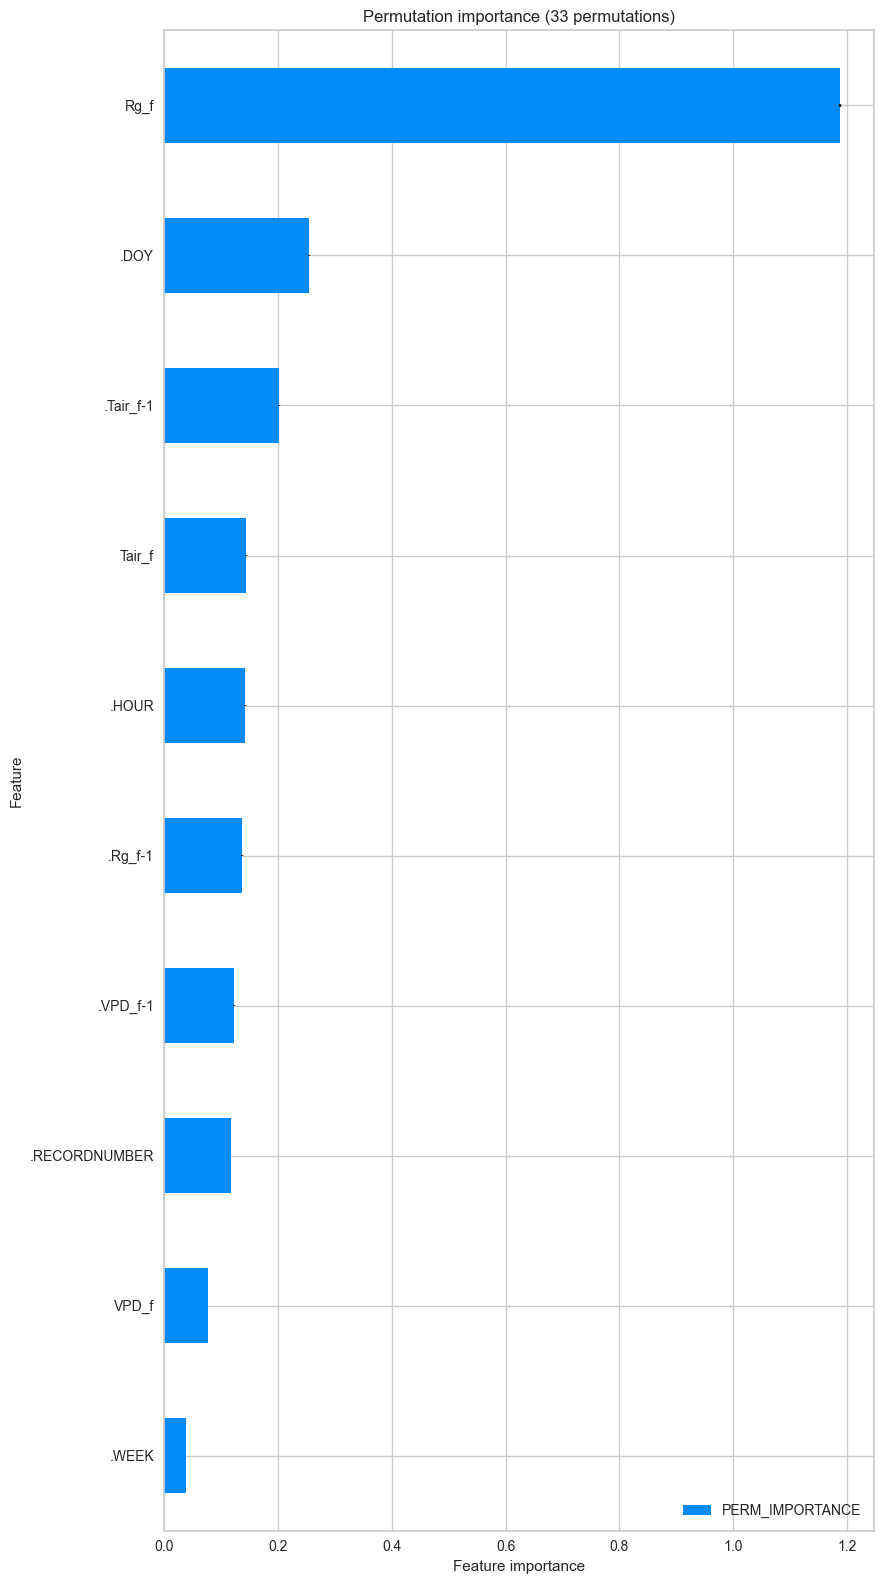

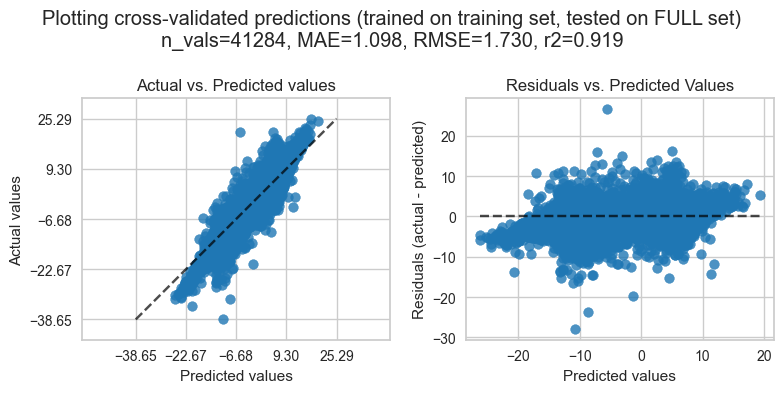

>>> Predicting target NEE_CUT_REF_orig where all features are available ... predicted 175295 records.
>>> Collecting results for final model ...
>>> Filling 134011 missing records in target with predictions from final model ...
>>> Storing gap-filled time series in variable NEE_CUT_REF_orig_gfRF ...
>>> Restoring original timestamp in results ...

Gap-filling 1 remaining missing records in NEE_CUT_REF_orig_gfRF using fallback model ...
>>> Fallback model is trained on NEE_CUT_REF_orig_gfRF and timestamp info ...
++ Added new columns with timestamp info: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] (ONLY FALLBACK)
>>> Predicting target NEE_CUT_REF_orig_gfRF using fallback model ...
>>> Combining predictions from full model and fallback model ...


In [14]:
rfts.fillgaps(showplot_scores=True, showplot_importance=True)

In [15]:
rfts.report_gapfilling()


GAP-FILLING RESULTS

Model scores and feature importances were calculated from high-quality predicted targets (134011 values, NEE_CUT_REF_orig_gfRF where flag=1) in comparison to observed targets (41284 values, NEE_CUT_REF_orig).

## TARGET
- first timestamp:  2013-01-01 00:15:00
- last timestamp:  2022-12-31 23:45:00
- potential number of values: 175296 values)
- target column (observed):  NEE_CUT_REF_orig
- missing records (observed):  134012 (cross-check from flag: 134012)
- target column (gap-filled):  NEE_CUT_REF_orig_gfRF  (175296 values)
- missing records (gap-filled):  0
- gap-filling flag: FLAG_NEE_CUT_REF_orig_gfRF_ISFILLED
  > flag 0 ... observed targets (41284 values)
  > flag 1 ... targets gap-filled with high-quality, all features available (134011 values)
  > flag 2 ... targets gap-filled with fallback (1 values)

## FEATURE IMPORTANCES
- names of features used in model:  ['Rg_f', '.DOY', '.Tair_f-1', 'Tair_f', '.HOUR', '.Rg_f-1', '.VPD_f-1', '.RECORDNUMBER', 'VPD_f', '

</br>

## Attributes
A lot more information about feature reduction, training and testing, model building and gap-filling is available via the class attributes.

In [16]:
rfts.feature_importances_

,PERM_IMPORTANCE,PERM_SD
Rg_f,1.187560,0.007480
.DOY,0.254853,0.002521
.Tair_f-1,0.201659,0.001922
Tair_f,0.144808,0.001279
.HOUR,0.142029,0.001848
.Rg_f-1,0.136880,0.001081
.VPD_f-1,0.123749,0.000818
.RECORDNUMBER,0.117705,0.000859
VPD_f,0.077365,0.000771
.WEEK,0.038840,0.000390


In [17]:
rfts.feature_importances_reduction_

,PERM_IMPORTANCE,PERM_SD
Rg_f,1.232897,0.007899
.DOY,0.241612,0.002963
.Tair_f-1,0.208743,0.002085
.HOUR,0.155900,0.001548
Tair_f,0.146522,0.001899
.Rg_f-1,0.138716,0.001270
.VPD_f-1,0.130136,0.000960
VPD_f,0.087728,0.000767
.RECORDNUMBER,0.064164,0.000544
.WEEK,0.038256,0.000440


In [18]:
rfts.feature_importances_traintest_

,PERM_IMPORTANCE,PERM_SD
Rg_f,1.057885,0.018474
.DOY,0.171048,0.005096
.Tair_f-1,0.123352,0.003871
Tair_f,0.081674,0.003365
.HOUR,0.069385,0.003306
.Rg_f-1,0.067084,0.002453
.VPD_f-1,0.061954,0.001909
.RECORDNUMBER,0.046003,0.001892
VPD_f,0.027855,0.001568
.WEEK,0.013323,0.000726


In [19]:
rfts.gapfilling_df_

,.PREDICTIONS_FULLMODEL,NEE_CUT_REF_orig,.GAP_PREDICTIONS,FLAG_NEE_CUT_REF_orig_gfRF_ISFILLED,NEE_CUT_REF_orig_gfRF,.PREDICTIONS_FALLBACK,.GAPFILLED_CUMULATIVE,.PREDICTIONS
TIMESTAMP_MIDDLE,,,,,,,,
2013-01-01 00:15:00,NaN,NaN,NaN,2.0,0.788365,0.788365,0.788365,0.788365
2013-01-01 00:45:00,0.454384,NaN,0.454384,1.0,0.454384,0.788365,1.242749,0.454384
2013-01-01 01:15:00,0.410970,NaN,0.410970,1.0,0.410970,0.535612,1.653718,0.410970
2013-01-01 01:45:00,0.488051,0.538,NaN,0.0,0.538000,0.535612,2.191718,0.488051
2013-01-01 02:15:00,-0.407475,NaN,-0.407475,1.0,-0.407475,0.179728,1.784243,-0.407475
...,...,...,...,...,...,...,...,...
2022-12-31 21:45:00,3.100202,NaN,3.100202,1.0,3.100202,3.214177,-60207.081787,3.100202
2022-12-31 22:15:00,3.516939,3.518,NaN,0.0,3.518000,3.397283,-60203.563787,3.516939
2022-12-31 22:45:00,3.305859,NaN,3.305859,1.0,3.305859,3.397283,-60200.257928,3.305859


In [20]:
rfts.model_

RandomForestRegressor(n_estimators=99, n_jobs=-1, random_state=42)

In [21]:
rfts.accepted_features_

['Rg_f',
 '.DOY',
 '.Tair_f-1',
 '.HOUR',
 'Tair_f',
 '.Rg_f-1',
 '.VPD_f-1',
 'VPD_f',
 '.RECORDNUMBER',
 '.WEEK']

In [22]:
rfts.rejected_features_

['.YEAR', '.SEASON', '.MONTH', '.YEARMONTH', '.YEARDOY', '.YEARWEEK']

In [23]:
rfts.scores_

{'mae': 1.098229684207642,
 'medae': 0.6895252525252502,
 'mse': 2.994393455225117,
 'rmse': 1.7304315806252257,
 'mape': 299675360783.0811,
 'maxe': 27.86641414141414,
 'r2': 0.9191399368444038}

In [24]:
rfts.scores_traintest_

{'mae': 2.221868837337894,
 'medae': 1.631767676767676,
 'mse': 9.65788839848094,
 'rmse': 3.107714336691991,
 'mape': 1303281105903.6611,
 'maxe': 27.86641414141414,
 'r2': 0.7420727031124259}

In [25]:
rfts.traintest_details_.keys()

dict_keys(['train_df', 'test_df', 'test_size', 'X_names', 'model'])

</br>

## Result

In [26]:
gapfilled = rfts.get_gapfilled_target()
gapfilled

TIMESTAMP_MIDDLE
2013-01-01 00:15:00    0.788365
2013-01-01 00:45:00    0.454384
2013-01-01 01:15:00    0.410970
2013-01-01 01:45:00    0.538000
2013-01-01 02:15:00   -0.407475
                         ...   
2022-12-31 21:45:00    3.100202
2022-12-31 22:15:00    3.518000
2022-12-31 22:45:00    3.305859
2022-12-31 23:15:00    3.931606
2022-12-31 23:45:00    5.300717
Freq: 30min, Name: NEE_CUT_REF_orig_gfRF, Length: 175296, dtype: float64

In [27]:
flag = rfts.get_flag()
flag

TIMESTAMP_MIDDLE
2013-01-01 00:15:00    2.0
2013-01-01 00:45:00    1.0
2013-01-01 01:15:00    1.0
2013-01-01 01:45:00    0.0
2013-01-01 02:15:00    1.0
                      ... 
2022-12-31 21:45:00    1.0
2022-12-31 22:15:00    0.0
2022-12-31 22:45:00    1.0
2022-12-31 23:15:00    1.0
2022-12-31 23:45:00    1.0
Freq: 30min, Name: FLAG_NEE_CUT_REF_orig_gfRF_ISFILLED, Length: 175296, dtype: float64

In [28]:
gapfilling_df = rfts.gapfilling_df_
gapfilling_df

,.PREDICTIONS_FULLMODEL,NEE_CUT_REF_orig,.GAP_PREDICTIONS,FLAG_NEE_CUT_REF_orig_gfRF_ISFILLED,NEE_CUT_REF_orig_gfRF,.PREDICTIONS_FALLBACK,.GAPFILLED_CUMULATIVE,.PREDICTIONS
TIMESTAMP_MIDDLE,,,,,,,,
2013-01-01 00:15:00,NaN,NaN,NaN,2.0,0.788365,0.788365,0.788365,0.788365
2013-01-01 00:45:00,0.454384,NaN,0.454384,1.0,0.454384,0.788365,1.242749,0.454384
2013-01-01 01:15:00,0.410970,NaN,0.410970,1.0,0.410970,0.535612,1.653718,0.410970
2013-01-01 01:45:00,0.488051,0.538,NaN,0.0,0.538000,0.535612,2.191718,0.488051
2013-01-01 02:15:00,-0.407475,NaN,-0.407475,1.0,-0.407475,0.179728,1.784243,-0.407475
...,...,...,...,...,...,...,...,...
2022-12-31 21:45:00,3.100202,NaN,3.100202,1.0,3.100202,3.214177,-60207.081787,3.100202
2022-12-31 22:15:00,3.516939,3.518,NaN,0.0,3.518000,3.397283,-60203.563787,3.516939
2022-12-31 22:45:00,3.305859,NaN,3.305859,1.0,3.305859,3.397283,-60200.257928,3.305859


</br>

## Plot

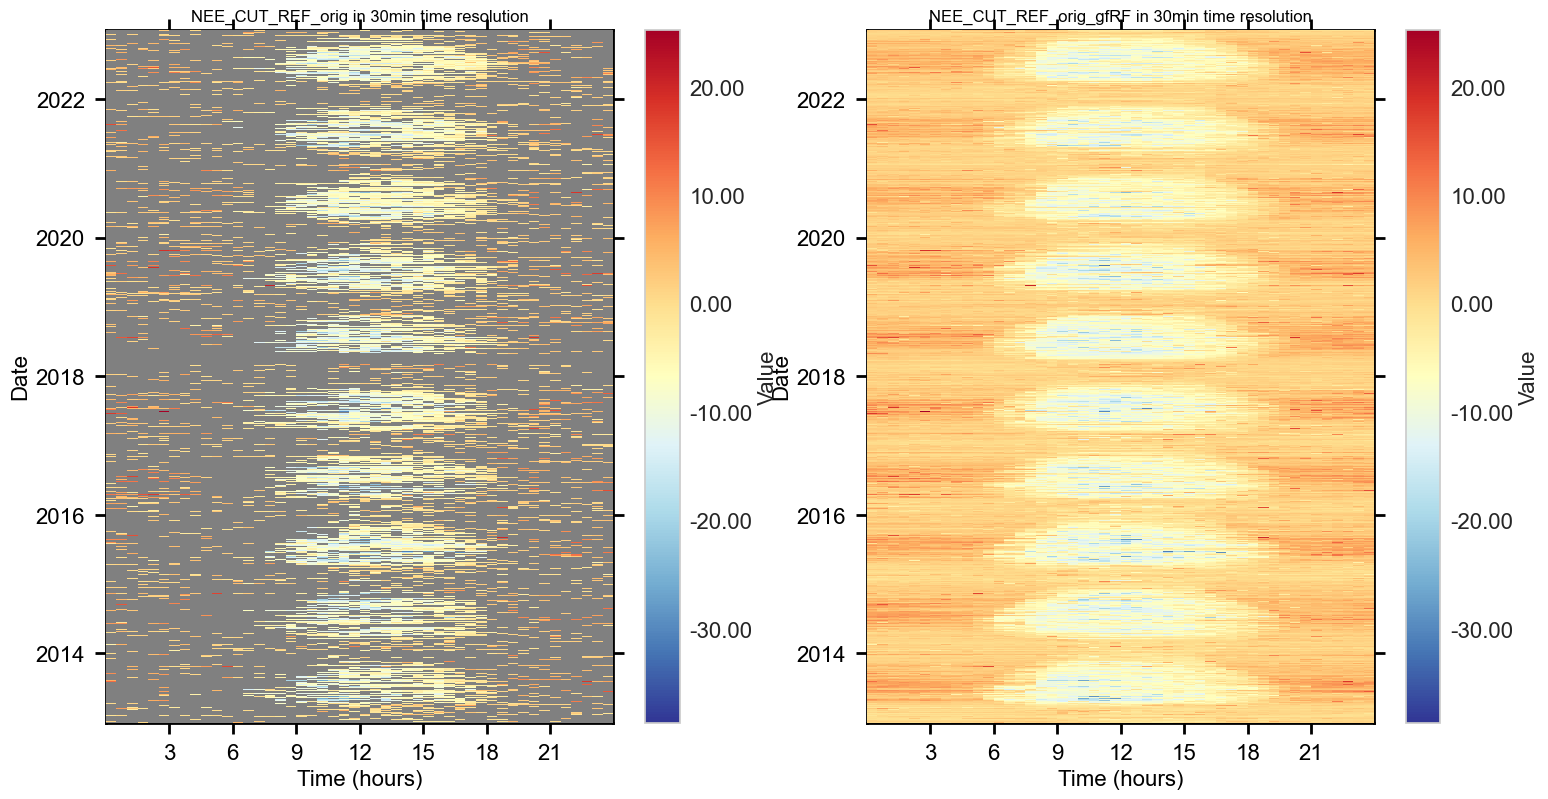

In [29]:
fig, axs = plt.subplots(ncols=2, figsize=(18, 9))
HeatmapDateTime(series=df[TARGET_COL], ax=axs[0]).plot()
HeatmapDateTime(series=gapfilled, ax=axs[1]).plot()

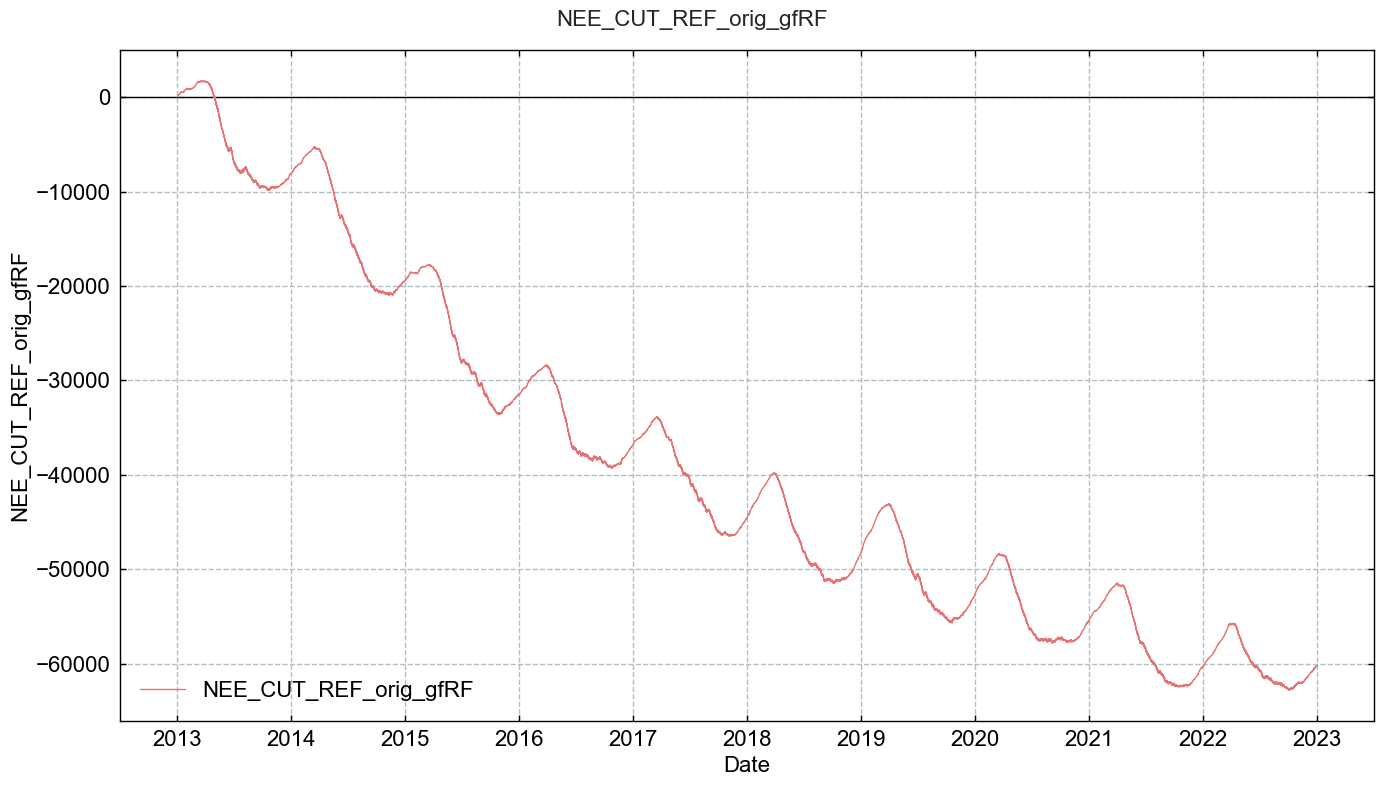

In [30]:
TimeSeries(series=gapfilled.cumsum()).plot()

</br>

# **End of notebook**
Congratulations, you reached the end of this notebook! Before you go let's store your finish time.

In [31]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished. {dt_string}")

Finished. 2024-08-22 15:52:29
